## Section 2: Model checking

这一章为了回答下面两个问题，我们要看两个技术：
1. 是否选择的模型及其参数能够在给定观测数据的前提下，拟合观测数据的真实分布函数
2. 给定两个不相关的模型，哪个可以更好的拟合观测数据的真实分布函数

### Model check I: Posterior predictive check
一种验证模型的拟合情况的方法称为posterior predictive check。这是个非常直观的技术。回想前一章从$\mu$的后验分布中，收集200.000个$\mu$的样本，这每个采样的$\mu$值都被认为是置信的参数。

posterior predictive check 要求从预测的模型中生成新的数据。这就是说我们构建了200.000个Poisson分布，并从这些分布中采集预测数据。这个可以形式化的表示为：
$$ p(\tilde{y}\ |y) = \int p(\tilde{y}\ |\theta) f(\theta\ |y) d\theta$$

最终，如果这个模型能够很好的拟合真实数据的分布，那么生成的数据也应该能够和原始的观测数据相似。pyMC 提供一个方便的方式从拟合的模型中生成数据：

`y_pred = pm.Poisson('y_pred', mu=mu)`

这个方法除了不指定使用观测数据外，和`y_est`一样。PyMC认为这是个stochastic node（和observed node相反的意思），它同时可以生成在`y_est`中的采样数据。

我们下面画出`y_pred`的图像和`y_est`对比。

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as stats
import statsmodels.api as sm
import theano.tensor as tt

from IPython.display import Image

%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

messages = pd.read_csv('data/hangout_chat_data.csv')

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


In [3]:
with pm.Model() as model:
    mu = pm.Uniform('mu', lower=0, upper=100)
    y_est = pm.Poisson('y_est', mu=mu, observed=messages['time_delay_seconds'].values)
    
    y_pred = pm.Poisson('y_pred', mu=mu)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(20000, step, start=start, progressbar=True)

Optimization terminated successfully.
         Current function value: 2509.140587
         Iterations: 5
         Function evaluations: 8
         Gradient evaluations: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20500/20500 [05:25<00:00, 63.02it/s]


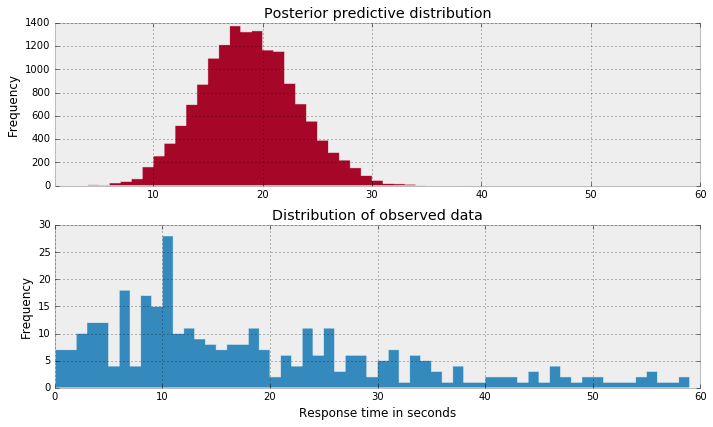

In [44]:
x_lim = 60
burnin = 5000

y_pred = trace[burnin:].get_values('y_pred')
mu_mean = trace[burnin:].get_values('mu').mean()

fig = plt.figure(figsize=(10, 6))
fig.add_subplot(211)

plt.hist(y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])
plt.xlim(1, x_lim)
plt.ylabel('Frequency')
plt.title('Posterior predictive distribution')

fig.add_subplot(212)
plt.hist(messages['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
plt.xlabel('Response time in seconds')
plt.ylabel('Frequency')
plt.title('Distribution of observed data')

plt.tight_layout()

### 选择正确的分布
上面的后验分布模型并不令人满意。理想情况下，我希望后验预测分布能够和观测的数据分布相似。直觉上，如果我正确的求出了观测数据的模型参数，那么我们应该可以从模型中采样出和观测数据相似的数据，而上面这个明显不对。

也许Poisson分布对这组观测数据不匹配。其他的选择比如用Negative Binomial distribution。它和Poisson分布很像，除了它有两个参数($\mu$ and $\alpha$)，使其能够独立于其平均值而改变其方差值。回忆下Poisson分布用单变量$\mu$来表示其分布的均值和方差。

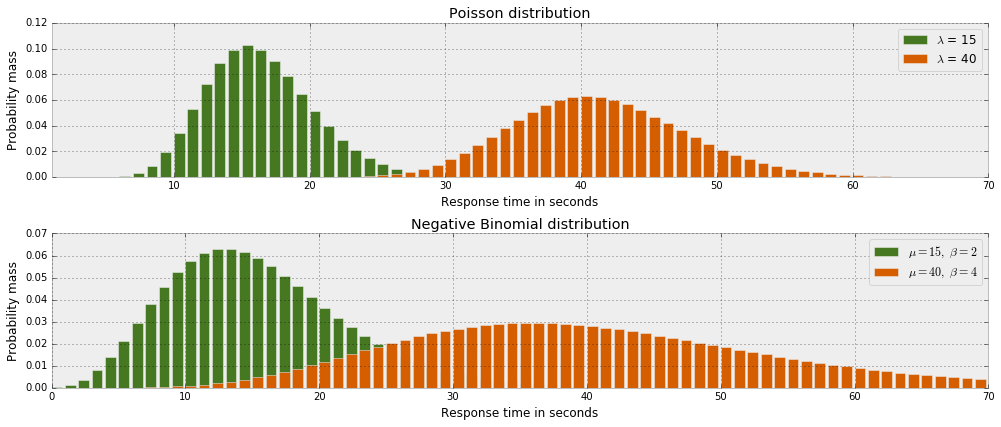

In [57]:
fig = plt.figure(figsize=(14, 6))
fig.add_subplot(211)
x_lim = 70
mu = [15, 40]
for i in np.arange(x_lim):
    plt.bar(i, stats.poisson.pmf(mu[0], i), color=colors[3])
    plt.bar(i, stats.poisson.pmf(mu[1], i), color=colors[4])
    
plt.xlim(1, x_lim)
plt.xlabel('Response time in seconds')
plt.ylabel('Probability mass')
plt.title('Poisson distribution')
plt.legend(['$\lambda$ = %s' % mu[0],
            '$\lambda$ = %s' % mu[1]])


# Scipy taks parameters n & p, not mu & alpha
def get_n(mu, alpha):
    return 1. / alpha * mu

def get_p(mu, alpha):
    return get_n(mu, alpha) / (get_n(mu, alpha) + mu)

fig.add_subplot(212)

a = [2, 4]

for i in np.arange(x_lim):
    plt.bar(i, stats.nbinom.pmf(i, n=get_n(mu[0], a[0]), p=get_p(mu[0], a[0])), color=colors[3])
    plt.bar(i, stats.nbinom.pmf(i, n=get_n(mu[1], a[1]), p=get_p(mu[1], a[1])), color=colors[4])
    
plt.xlabel('Response time in seconds')
plt.ylabel('Probability mass')
plt.title('Negative Binomial distribution')
plt.legend(['$\\mu = %s, \\ \\beta = %s$' % (mu[0], a[0]),
            '$\\mu = %s, \\ \\beta = %s$' % (mu[1], a[1])])


plt.tight_layout()

上图可以看出，Negative Binomial分布对观测数据拟合的更好，接下来，我们就要进行分布的参数估计。这个分布模型可以被表示为如下公式：

$$ y_j \sim NegBinomial(\mu, \alpha) $$
$$\alpha = Exponential(0.2)$$
$$\mu = Uniform(0, 100)$$

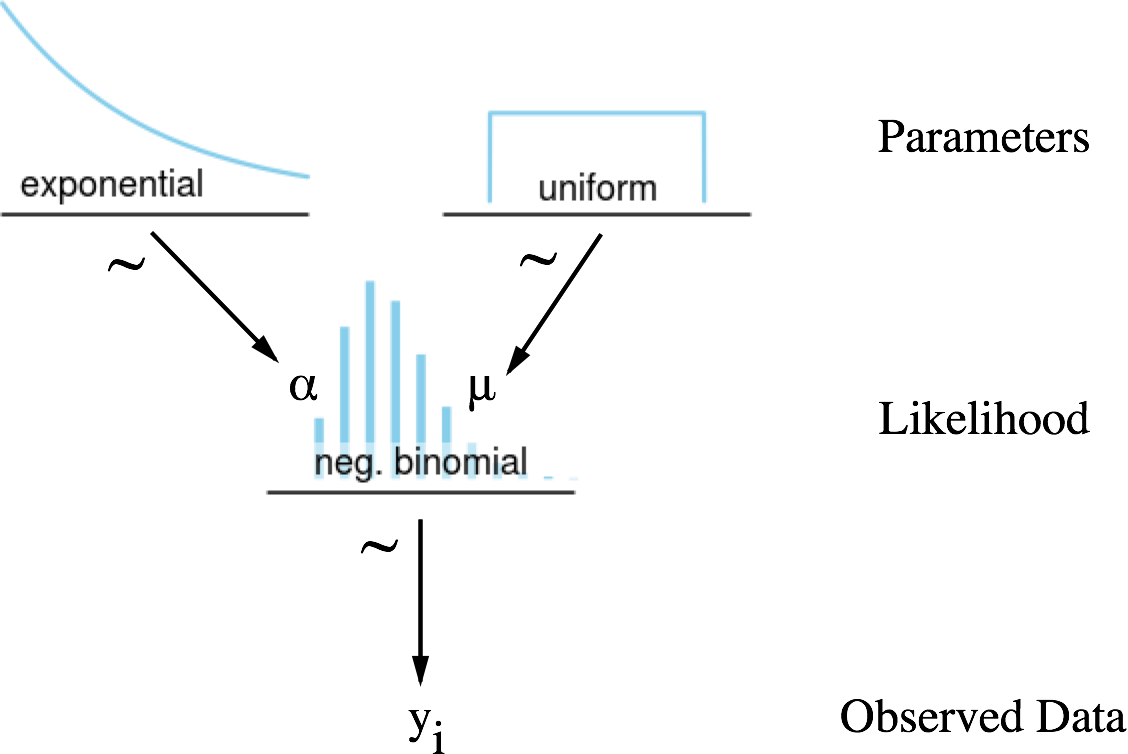

In [58]:
Image('graphics/Neg Binomial Dag.png', width=400)

In [59]:
with pm.Model() as model:
    alpha = pm.Exponential('alpha', lam=.2)
    mu = pm.Uniform('mu', lower=0, upper=100)
    
    y_pred = pm.NegativeBinomial('y_pred', mu=mu, alpha=alpha)
    y_est = pm.NegativeBinomial('y_est', mu=mu, alpha=alpha, observed=messages['time_delay_seconds'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(20000, step, start=start, progressbar=True)

Optimization terminated successfully.
         Current function value: 1317.850733
         Iterations: 13
         Function evaluations: 20
         Gradient evaluations: 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20500/20500 [17:46<00:00, 18.67it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000013858128>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000000138B74E0>]], dtype=object)

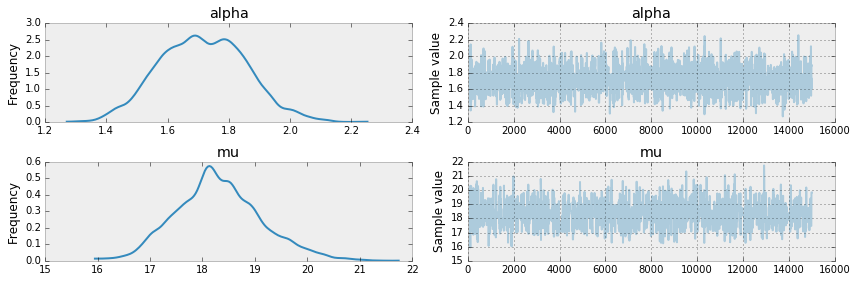

In [63]:
pm.traceplot(trace[burnin:], varnames=['alpha', 'mu'])

对比Poisson和Negative Binomial分布，我们发现后者对消息的平均回应时间($\mu$)给出了更好的估计：
- Poisson：17-19
- Negative Binomial: 16-21

除此之外， Negative Binomial模型的$\alpha$参数取值范围从1.2到2.2，这样就增加了求得的$\mu$值的方差。让我们看看posterior predictive distribution的拟合情况。

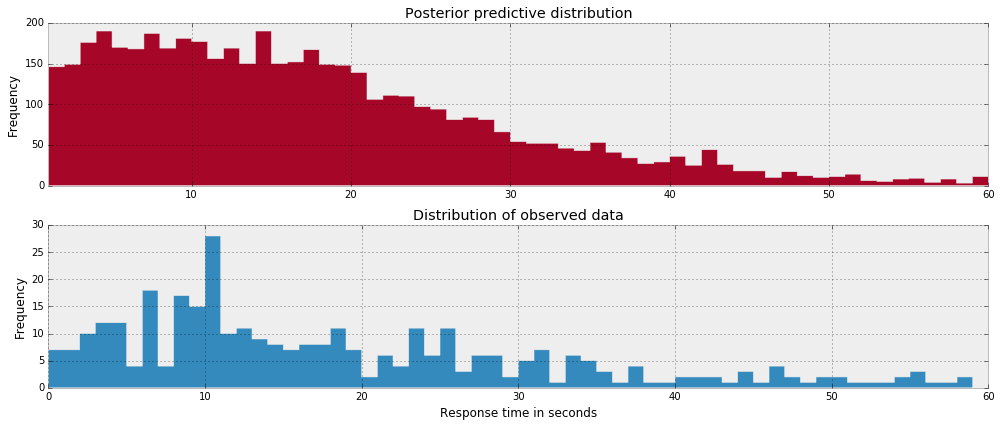

In [62]:
x_lim = 60
y_pred = trace[:burnin].get_values('y_pred')

fig = plt.figure(figsize=(14, 6))
fig.add_subplot(211)

plt.hist(y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])
plt.xlim(1, x_lim)
plt.ylabel('Frequency')
plt.title('Posterior predictive distribution')

fig.add_subplot(212)

plt.hist(messages['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
plt.xlabel('Response time in seconds')
plt.ylabel('Frequency')
plt.title('Distribution of observed data')

plt.tight_layout()

这两个分布看起来更相似了，所以可以得出结论：Negative Binomial model对观测数据拟合的更好。

### Model Check ||: Bayes Factor
另外一个技术是计算Bayes factor。这是个分析方法，用于比较两个模型。

贝叶斯因子通常是个很难计算的度量，因为它需要对全部联合概率分布进行积分。在一个低维度空间里，积分是可能的。但是只是进入适当的维度空间，对全部联合概率分布进行积分就变得计算成本高昂且耗时。

有一种类似的技术来替代原始的贝叶斯因子的计算技术。它是通过将要比较的两个模型组合成具有模型参数索引($\tau$)的层级模型。这个索引作用是切换两个模型中的一个并使用其中一个，这个切换机制在MCMC过程中，通过比较两个模型谁置信度高而使用谁。因此，模型索引的历史记录可以告诉我们更多关于两个模型之间的置信程度。

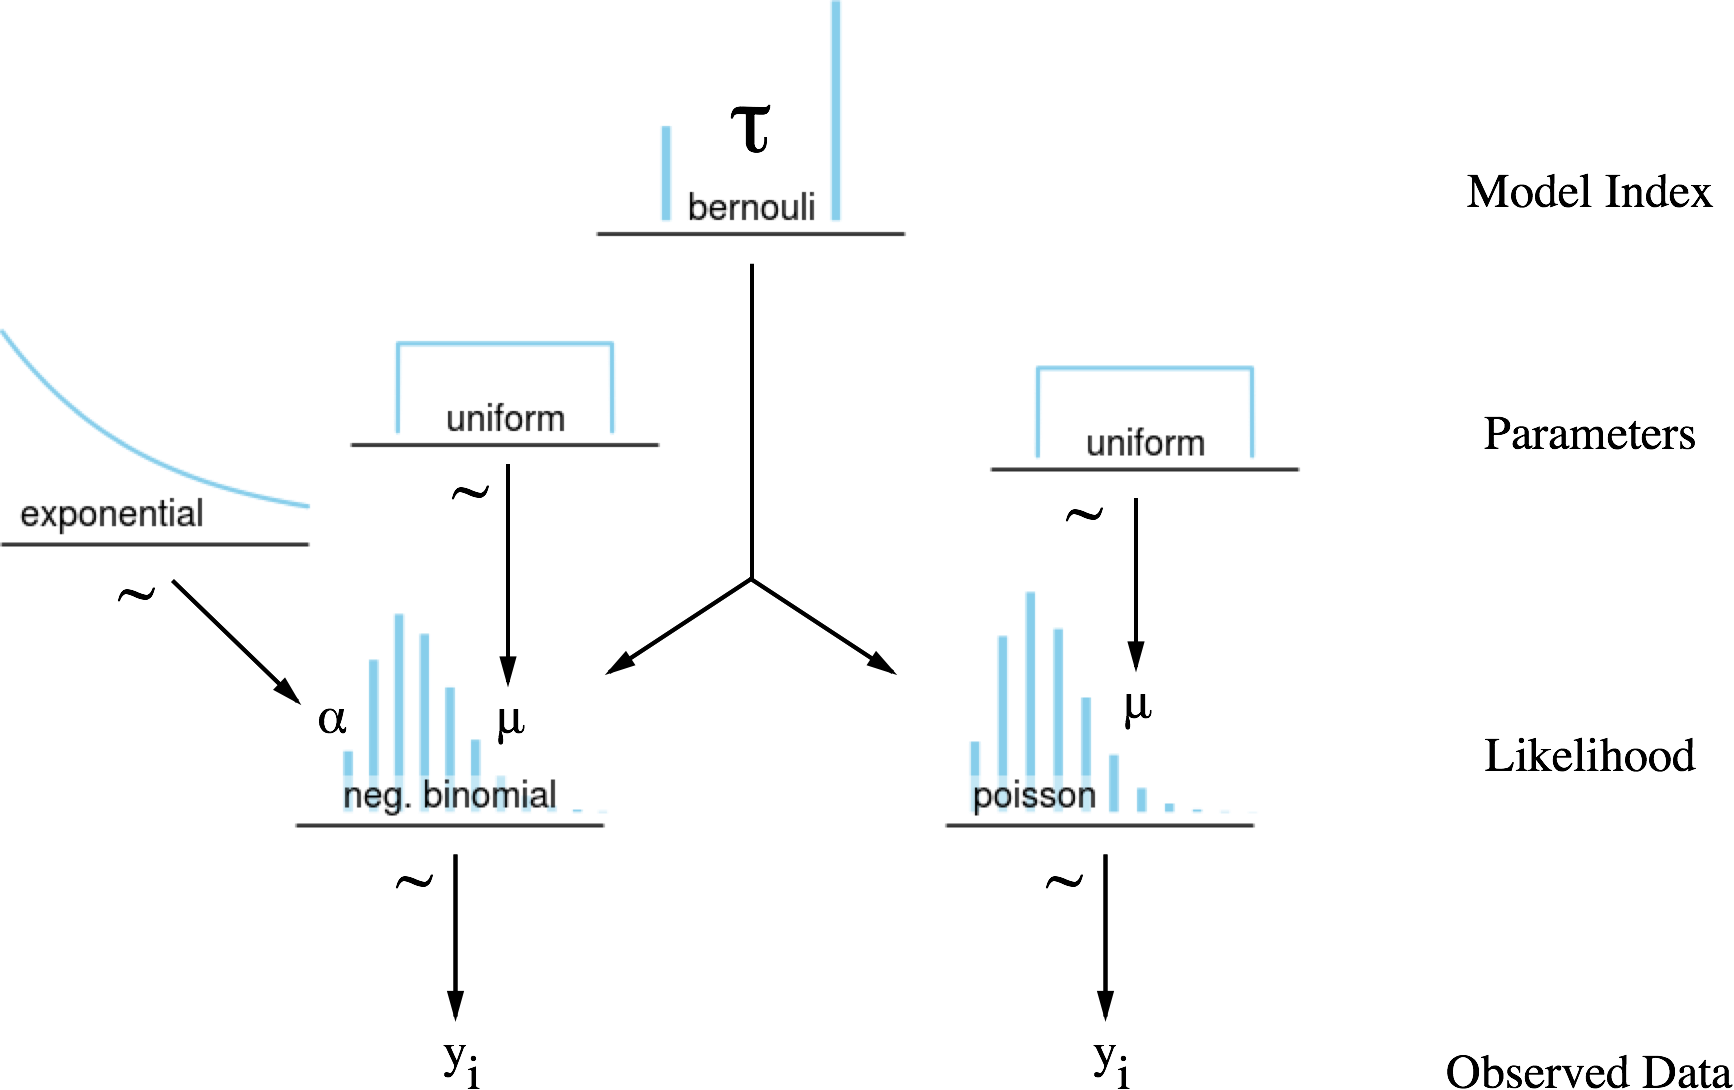

In [64]:
Image('graphics/Bayes Factor DAG.png', width=540)

In [65]:
with pm.Model() as model:
    
    # Index to true model
    prior_model_prob = 0.5
    # tau = pm.DiscreteUniform('tau', lower=0, upper=1)
    tau = pm.Bernoulli('tau', prior_model_prob)
    
    # Poisson parameters
    mu_p = pm.Uniform('mu_p', 0, 60)
    
    # Negative Binomial parameters
    alpha = pm.Exponential('alpha', lam=0.2)
    mu_nb = pm.Uniform('mu_nb', lower=0, upper=60)
    
    y_like = pm.DensityDist('y_like',
                           lambda value: pm.math.switch(tau,
                                                       pm.Poisson.dist(mu_p).logp(value),
                                                       pm.NegativeBinomial.dist(mu_nb, alpha).logp(value)),
                           observed=messages['time_delay_seconds'].values)
    
    start = pm.find_MAP()
    step1 = pm.Metropolis([mu_p, alpha, mu_nb])
    step2 = pm.ElemwiseCategorical(vars=[tau], values=[0, 1])
    trace = pm.sample(20000, step=[step1, step2], start=start)

Optimization terminated successfully.
         Current function value: 1313.791363
         Iterations: 8
         Function evaluations: 24
         Gradient evaluations: 18


D:\Users\ZB-TQ-G1010448\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20500/20500 [48:38<00:00,  7.01it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000015199358>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000000151AD860>]], dtype=object)

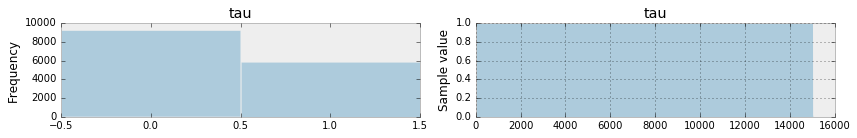

In [66]:
pm.traceplot(trace[burnin:], varnames=['tau'])

我们可以用下面的公式计算上面两个模型的贝叶斯因子：

$$Posterior Odds = BayesFactor * PriorOdds$$

$$\frac{P(Data \ | \ M_1)}{P(Data \ | \ M_2)} =  B.F. \times \frac{P(M_1)}{P(M_2)}$$

在上面的例子里，没对任何一个模型应用先验概率， 因此贝叶斯因子只是模型似然估计值的商。如果你发现MCMC采集器没有在两个模型之间切换，你可以引入先验概率，这样可以帮助模型充分使用两个模型。


In [67]:
# Compute the Bayes factor
prob_pois = trace[burnin:]['tau'].mean()
prob_nb = 1 - prob_pois
BF = (prob_nb / prob_pois) * (prior_model_prob/ (1 - prior_model_prob))
print('Bayes Factor: %s' %BF)

Bayes Factor: 1.5817555938


贝叶斯因子 > 1 说明 $M_1$(Negative Binomial) 比 $M_2$（Poisson）有更强的支持度。 Jeffreys' scale of evidence for Bayes factors interprets a BF of 1.60 as there being weak evidence of $M_1$ over $M_2$ given the data。结合后验预测检验和贝叶斯因子，可以得出结论：Negative Binomial更能拟合这组数据。

| Bayes Factor                            | Interpretation                      |
|-----------------------------------------|-------------------------------------|
| BF($M_1, M_2$) < 1/10       | Strong evidence for $M_2$   |
| 1/10 < BF($M_1, M_2$),< 1/3 | Moderate evidence for $M_2$ |
| 1/3 < BF($M_1, M_2$) < 1    | Weak evidence for $M_2$     |
| 1 < BF($M_1, M_2$) < 3      | Weak evidence for $M_1$     |
| 3 < BF($M_1, M_2$) < 10     | Moderate evidence for $M_1$ |
| BF($M_1, M_2$) > 10         | Strong evidence for $M_1$   |

### References
1. Jeffreys' scale of evidence, Humboldt University of Berlin. [Link](http://fedc.wiwi.hu-berlin.de/xplore/ebooks/html/csa/node124.html)
2. Model checking and diagnostics, PyMC2 Documentation. [Link](https://pymc-devs.github.io/pymc/modelchecking.html)
3. Compute Bayes factor using PyMC3, Chris Fonnesbeck. [GitHub Issue](https://github.com/pymc-devs/pymc3/issues/812)
4. [Doing Bayesian Data Analysis](http://www.amazon.com/Doing-Bayesian-Analysis-Second-Edition/dp/0124058884/ref=dp_ob_title_bk) by John Kruschke

In [68]:
# Apply pretty styles
from IPython.core.display import HTML

def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()